In [8]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import yaml

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%autoreload 2

In [11]:
from mushroom.mushroom_v4 import Mushroom

In [12]:
# !pip install vector-quantize-pytorch

In [13]:
import mushroom.utils as utils

In [14]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [15]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [35]:
mushroom_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .001,
        'recon_scaler': 1.,
        'encoder_dim': 256,
        'decoder_dim': 256,
    },
    'learner_kwargs': {
        'scale': .1,
#         'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 4,
        'device': 'cuda:3',
#         'channels': channels,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [36]:
# for config_fp in config_fps:
#     config = yaml.safe_load(open(config_fp))
#     case = config_fp.split('/')[-2]
#     print(case)
    
#     out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs')
#     chkpt_dir = os.path.join(out_dir, 'chkpts')
#     Path(chkpt_dir).mkdir(parents=True, exist_ok=True)
    
#     mushroom_config['sections'] = config
#     mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
    
#     mushroom = Mushroom.from_config(mushroom_config)
    
#     mushroom.train()
#     mushroom.chkpt_filepath = ''
#     mushroom.embed_sections()
#     mushroom.cluster_sections(margin=.05)

#     mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))
#     mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))
    
# #     break
    
    

In [37]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
config = yaml.safe_load(open(config_fp))
case = config_fp.split('/')[-2]

out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vae_vq_multiplex/outputs')
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [38]:
mushroom_config['sections'] = config
mushroom_config['train_kwargs']['save_dir'] = chkpt_dir

In [39]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda:3
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [40]:
b = next(iter(mushroom.learner.train_dl))

In [41]:
with torch.no_grad():
    
    device = mushroom.learner.device
    img_x = torch.stack((b['anchor_img'], b['pos_img'], b['neg_img']))
    section_x = torch.stack((b['anchor_idx'], b['pos_idx'], b['neg_idx']))
    img_x, section_x = img_x.to(device), section_x.to(device)

    losses, outputs = mushroom.learner.sae(img_x, section_x)

In [42]:
losses

{'overall_loss': tensor(1.4596, device='cuda:3'),
 'recon_loss': tensor(1.3937, device='cuda:3'),
 'triplet_loss': tensor(65.9360, device='cuda:3')}

In [ ]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(1.5194, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4536, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.8458, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1_vae_vq_multiplex/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(1.4697, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.4438, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(25.8942, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(1.1583, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1408, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(17.5395, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 30: {'overall_loss': tensor(1.3016, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2891, device='cu

INFO:root:iteration 340: {'overall_loss': tensor(1.1218, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1015, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(20.2846, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 350: {'overall_loss': tensor(0.9641, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9424, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(21.6682, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 360: {'overall_loss': tensor(1.1153, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0935, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(21.7197, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 370: {'overall_loss': tensor(1.0929, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0713, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(21.6333, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 380:

INFO:root:iteration 680: {'overall_loss': tensor(1.1999, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1658, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(34.1406, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 690: {'overall_loss': tensor(1.3651, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.3282, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(36.8528, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 700: {'overall_loss': tensor(1.1223, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0911, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(31.1863, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 710: {'overall_loss': tensor(1.0954, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0643, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(31.0312, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 720:

INFO:root:iteration 1020: {'overall_loss': tensor(1.1044, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0672, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(37.1821, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1030: {'overall_loss': tensor(1.0719, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0354, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(36.5190, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1040: {'overall_loss': tensor(1.2165, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1730, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(43.5114, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1050: {'overall_loss': tensor(0.9766, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9391, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(37.5088, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 1360: {'overall_loss': tensor(1.1620, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1201, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(41.8639, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1370: {'overall_loss': tensor(1.0128, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9787, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(34.0953, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1380: {'overall_loss': tensor(0.8991, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8608, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(38.3409, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1390: {'overall_loss': tensor(1.0116, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9722, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(39.4339, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 1690: {'overall_loss': tensor(1.0134, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9661, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(47.3721, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1700: {'overall_loss': tensor(1.0257, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9860, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(39.6045, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1710: {'overall_loss': tensor(0.9983, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9597, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(38.5792, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1720: {'overall_loss': tensor(1.1178, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0733, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(44.5628, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2020: {'overall_loss': tensor(1.1676, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1191, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(48.4680, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2030: {'overall_loss': tensor(1.0776, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0339, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(43.7285, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2040: {'overall_loss': tensor(1.2016, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1541, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(47.5173, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2050: {'overall_loss': tensor(1.0469, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0026, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(44.2824, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2360: {'overall_loss': tensor(1.0430, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0015, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(41.5500, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2370: {'overall_loss': tensor(1.1014, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0524, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(49.0166, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2380: {'overall_loss': tensor(1.0645, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0155, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(48.9767, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2390: {'overall_loss': tensor(1.0166, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9780, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(38.5497, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2690: {'overall_loss': tensor(1.0225, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9776, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(44.8916, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2700: {'overall_loss': tensor(0.9778, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9336, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(44.1998, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2710: {'overall_loss': tensor(1.0872, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0320, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(55.2690, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2720: {'overall_loss': tensor(1.2244, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1732, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(51.1403, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3020: {'overall_loss': tensor(1.1670, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1134, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(53.6648, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3030: {'overall_loss': tensor(1.0346, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9886, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(46.0039, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3040: {'overall_loss': tensor(1.2878, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2366, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(51.2333, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3050: {'overall_loss': tensor(0.9685, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9219, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(46.5383, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3360: {'overall_loss': tensor(0.9372, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8929, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(44.3122, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3370: {'overall_loss': tensor(1.1568, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1080, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(48.7502, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3380: {'overall_loss': tensor(1.1987, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1416, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(57.1205, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3390: {'overall_loss': tensor(1.0680, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0230, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(45.0411, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3690: {'overall_loss': tensor(1.1136, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0613, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(52.3489, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3700: {'overall_loss': tensor(1.1517, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0891, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(62.5941, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3710: {'overall_loss': tensor(1.0943, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0404, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(53.9548, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3720: {'overall_loss': tensor(0.9927, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9461, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(46.6557, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

In [17]:
# mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))

In [18]:
# mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [19]:
os.path.join(out_dir, 'outputs.pt')

'/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1_vae_vq/outputs/outputs.pt'

In [20]:
d = torch.load('/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt')
d.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [28]:
d['recon_embs']

tensor([[[[ 2.3089e-01,  2.5042e-01,  4.0160e-02,  ...,  2.5042e-01,
            4.0160e-02,  3.1269e-01],
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          ...,
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          [ 1.6370e-01, -1.5678e-02,  2.3870e-01,  ..., -1.5678e-02,
            2.3870e-01,  2.3675e-01]],

         [[-1.2238e-03,  2.2336e-02,  1.0044e-02,  ...,  2.2336e-02,
            1.0044e-02, -1.7283e-02],
          [ 4.2599e-02,  2.7280e-02,  9.8601e-02,  ...,  2.7280e-02,
            9.8601e-02,  1.3791e-02],
          [-3.0337e-02,  1.7819e-02,  7.7605e-02,  ...,  1.7819e-02,
            7.7605e-02,  9.4206e-02],
          ...,
     

In [14]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/chkpts/500iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [22]:
mushroom.chkpt_filepath = ''
mushroom.cluster_kwargs['centroids'] = None

In [21]:
mushroom.embed_sections()

In [18]:
# mushroom.recon_embs_prequant.shape

In [22]:
from einops import rearrange
dists = torch.cdist(rearrange(mushroom.recon_embs_prequant, 'n d h w -> n h w d'),
                    mushroom.learner.sae.vq.codebook.clone().cpu()).detach().cpu()
dists.shape

torch.Size([2, 60, 60, 100])

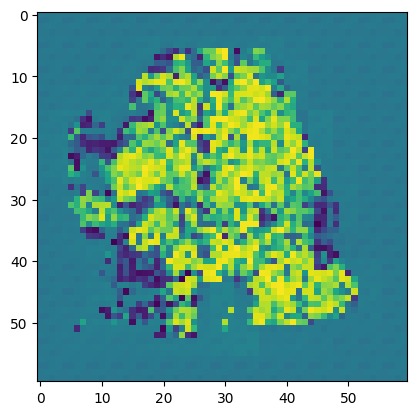

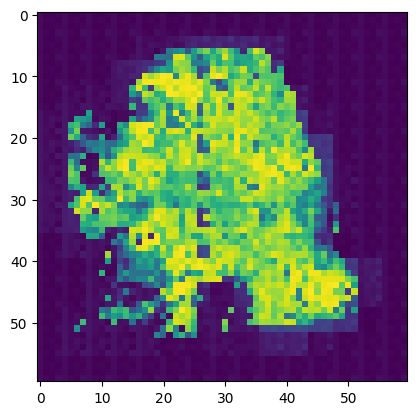

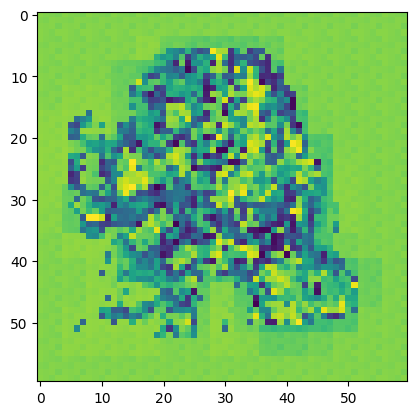

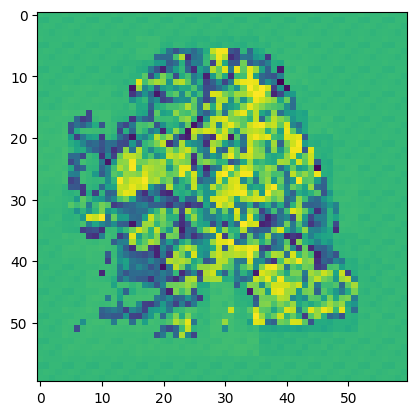

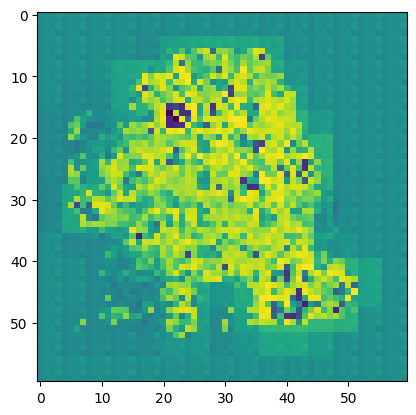

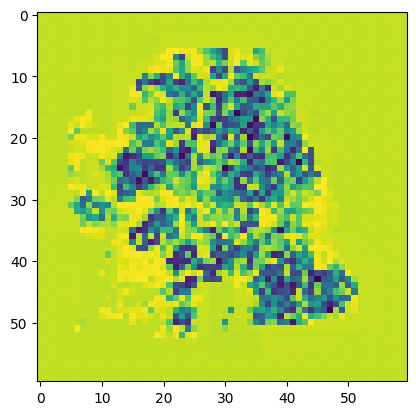

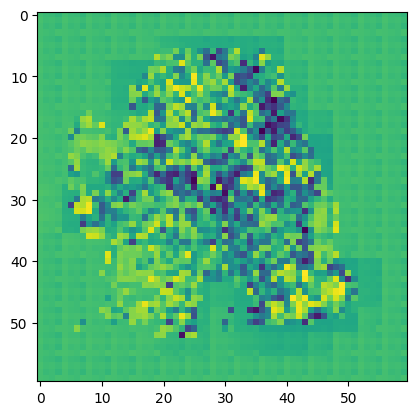

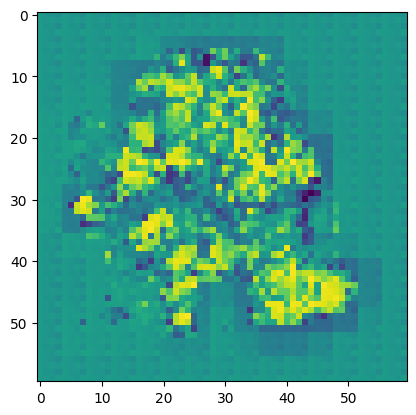

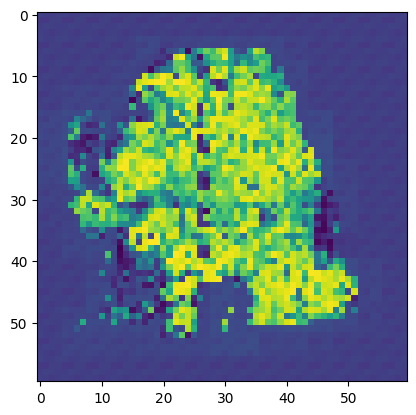

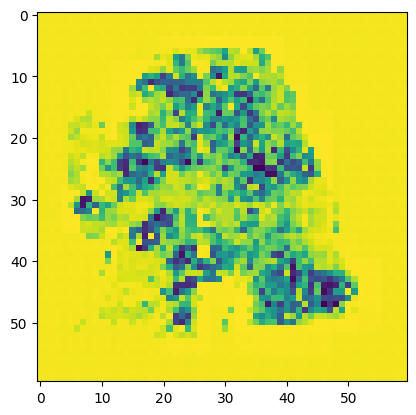

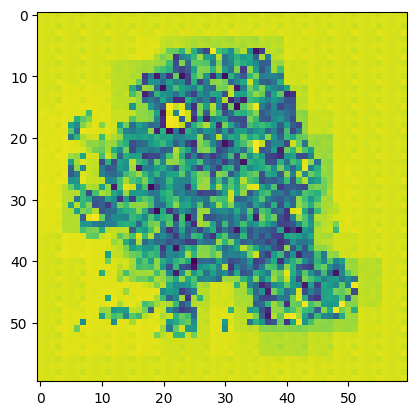

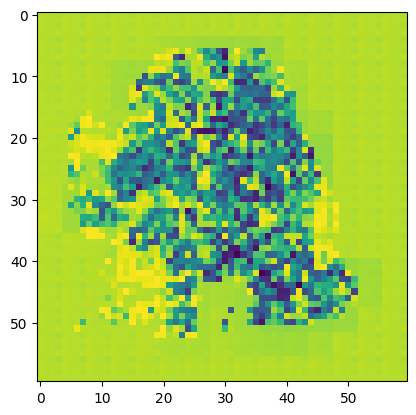

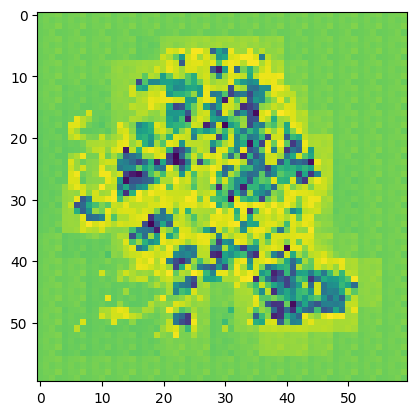

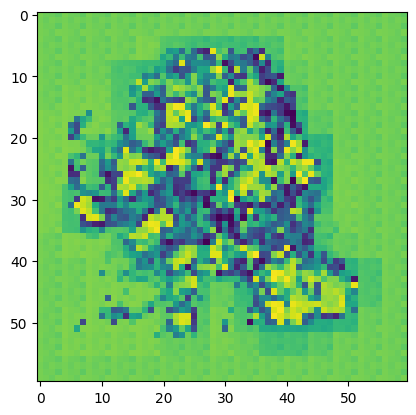

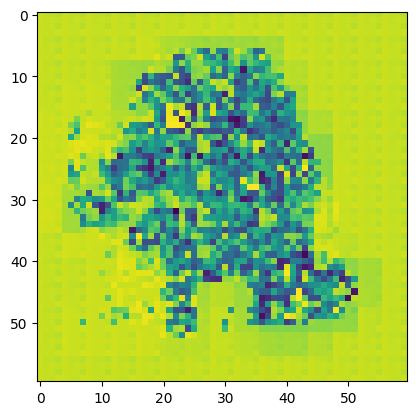

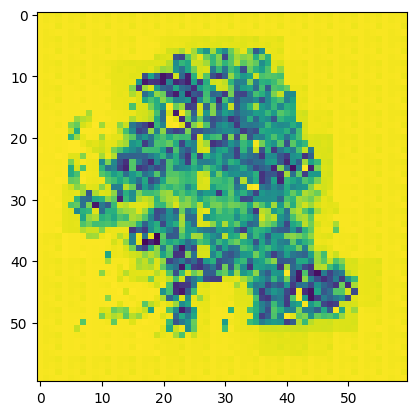

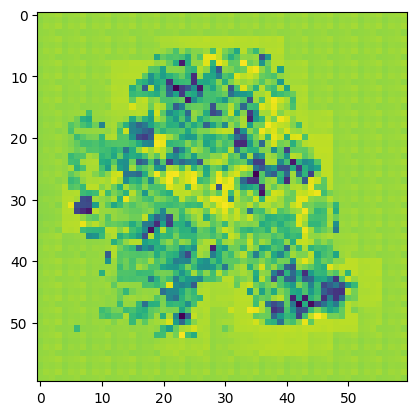

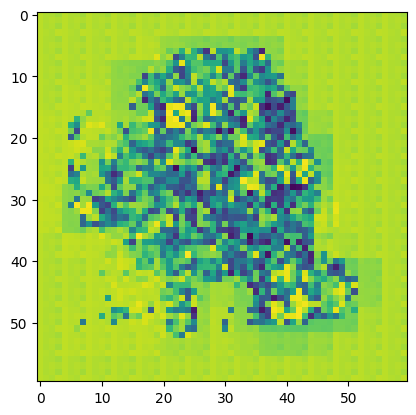

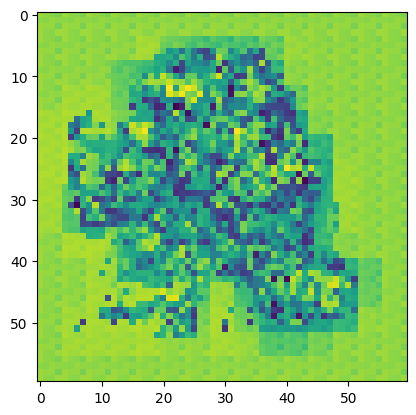

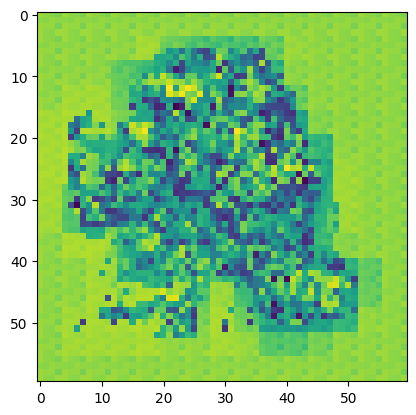

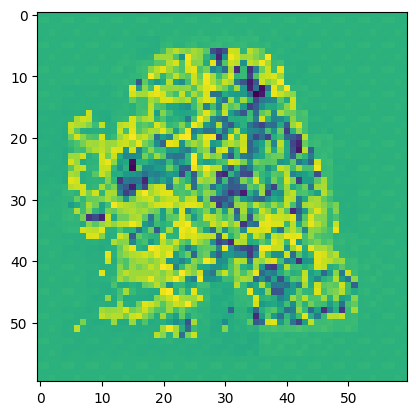

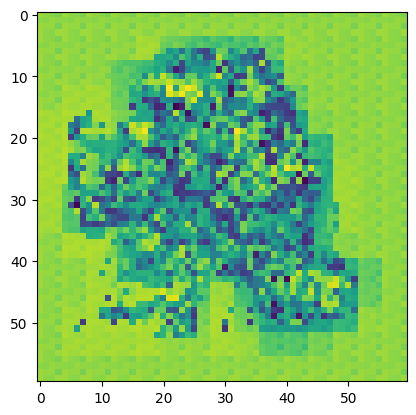

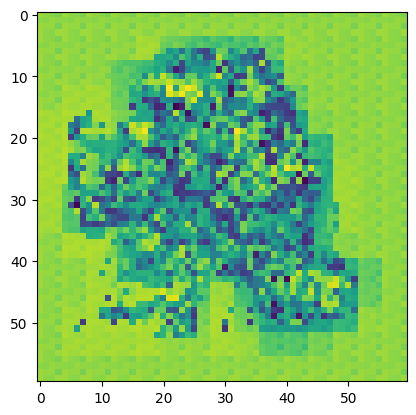

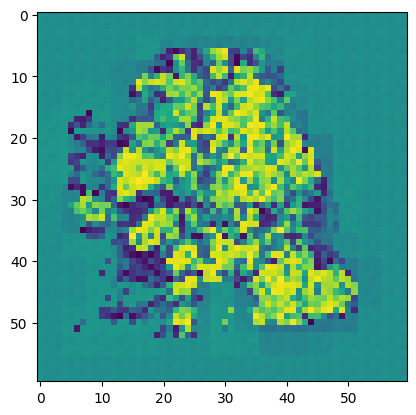

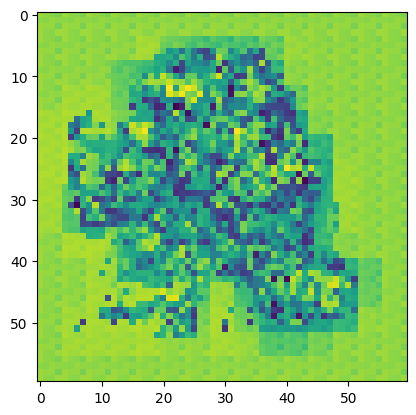

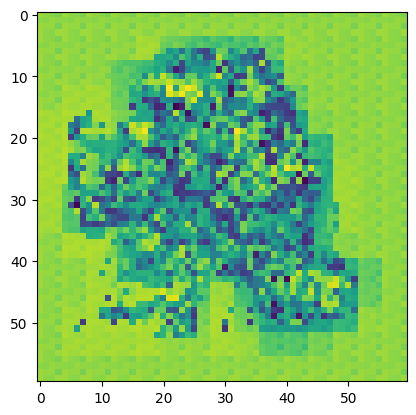

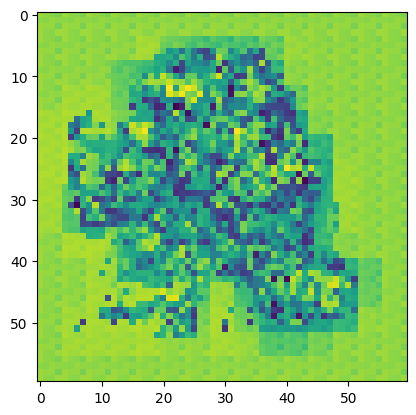

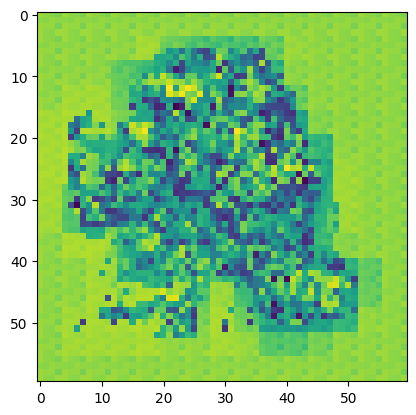

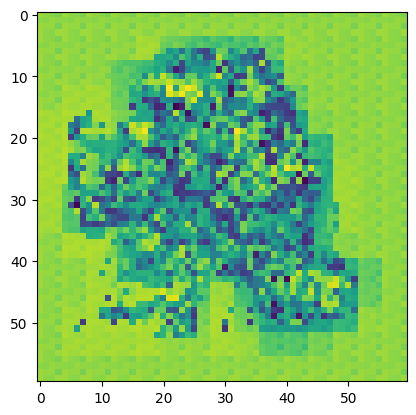

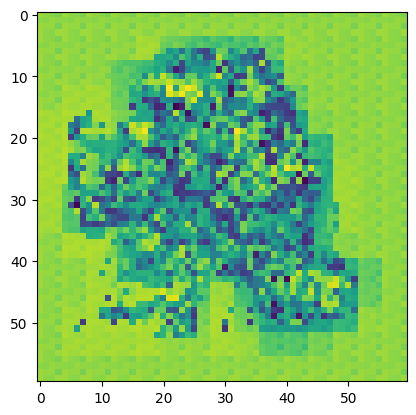

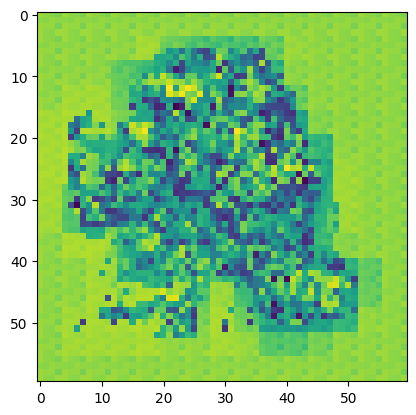

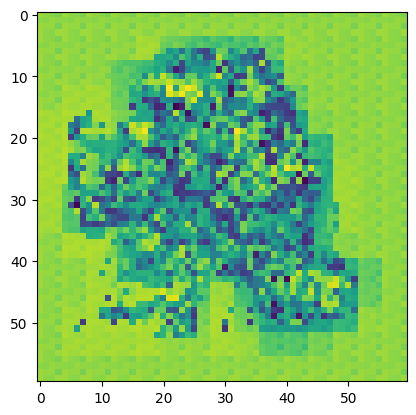

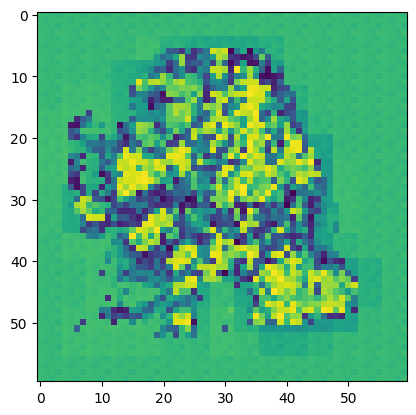

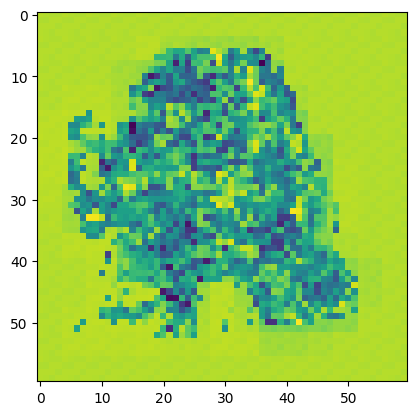

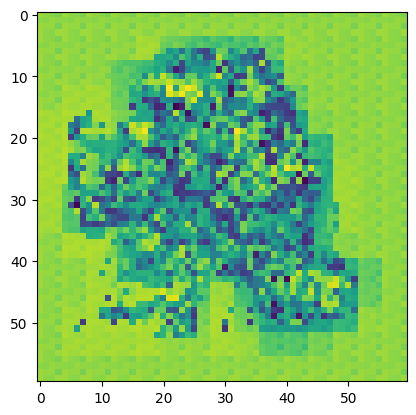

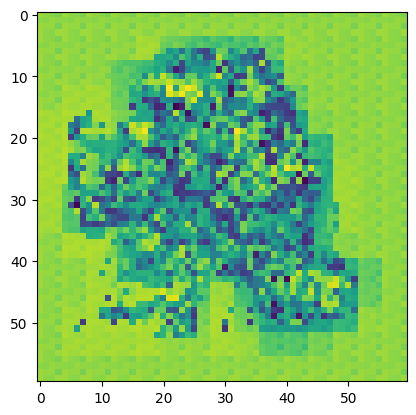

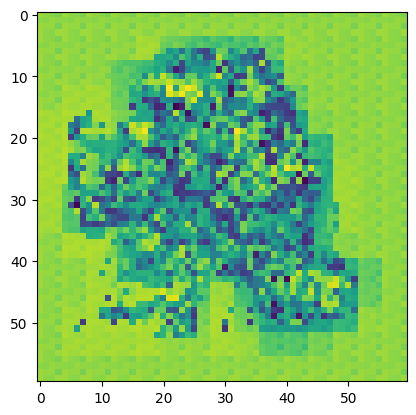

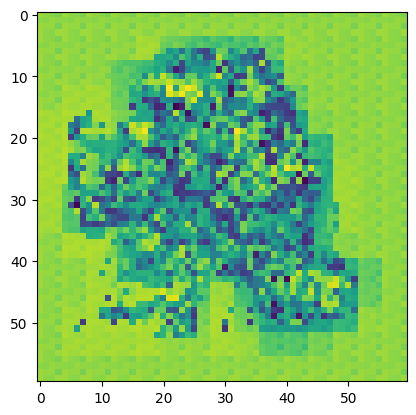

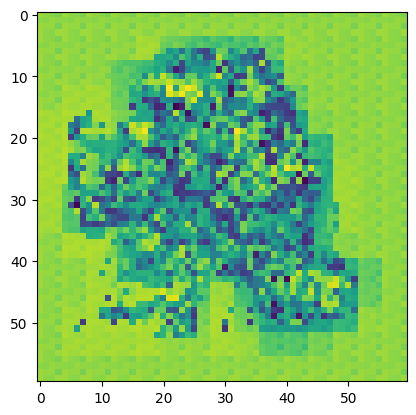

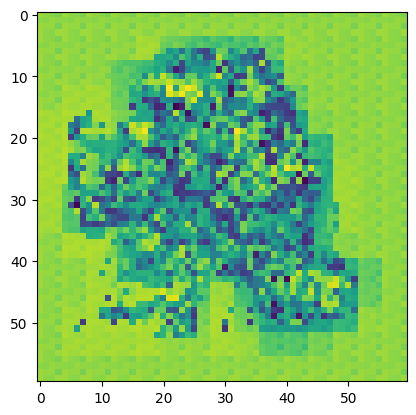

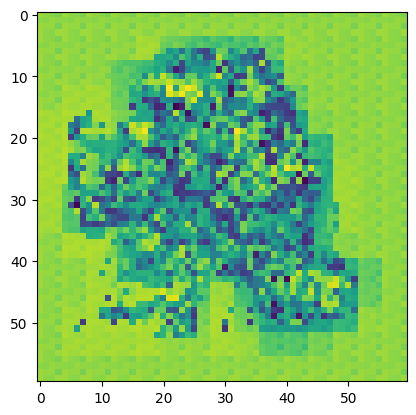

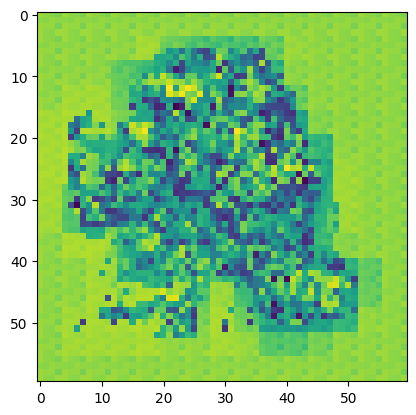

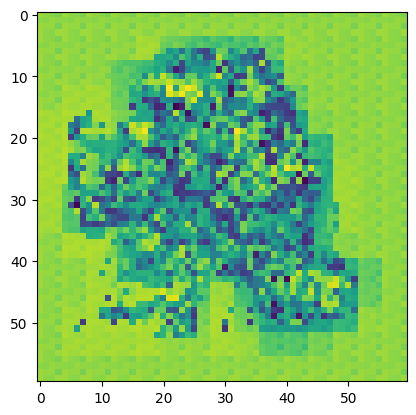

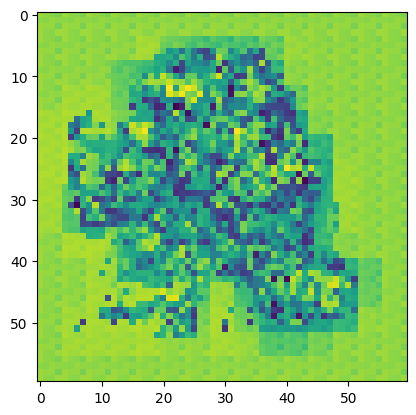

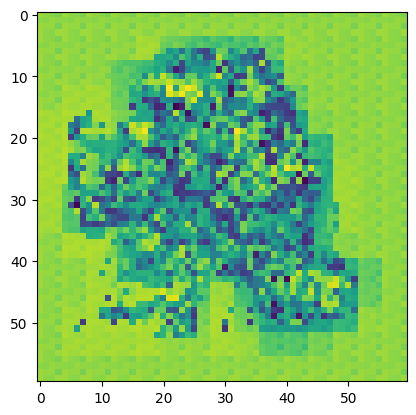

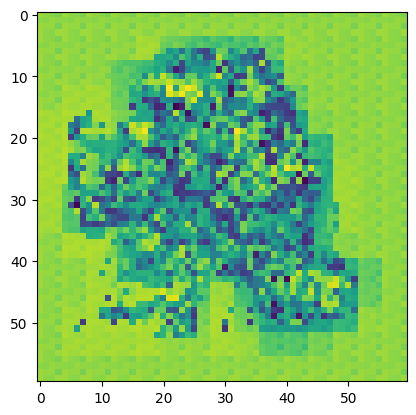

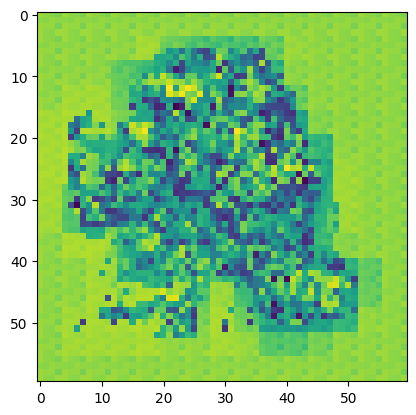

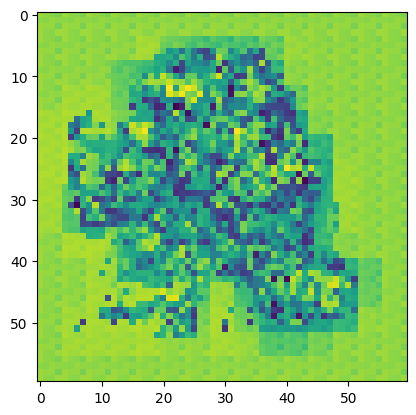

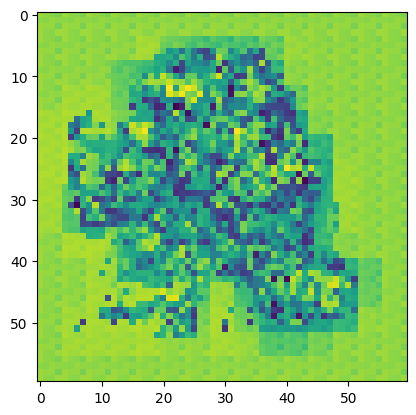

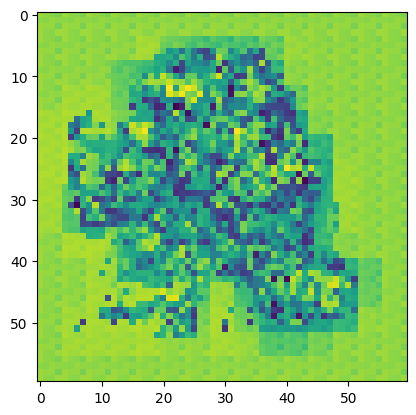

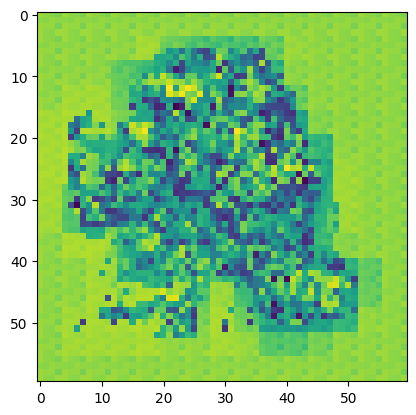

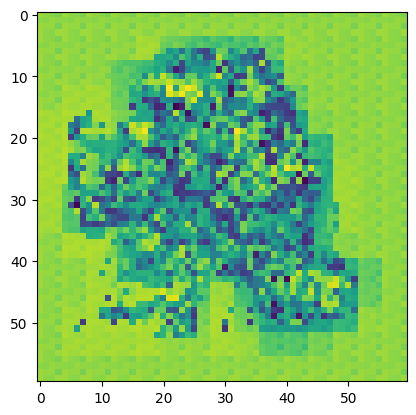

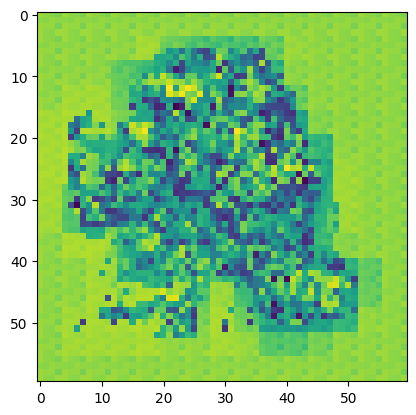

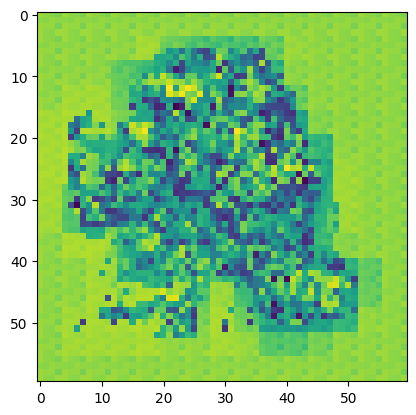

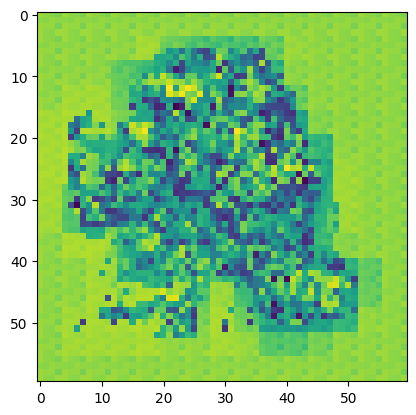

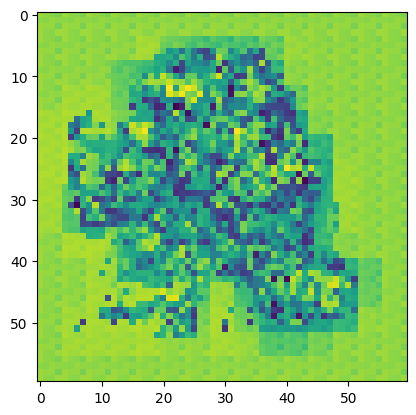

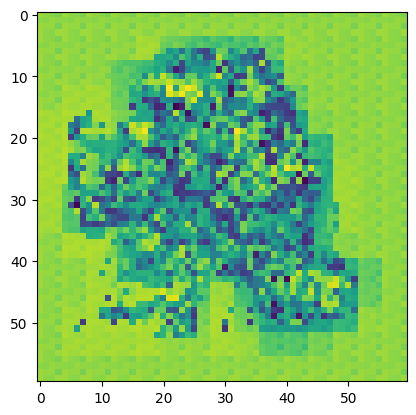

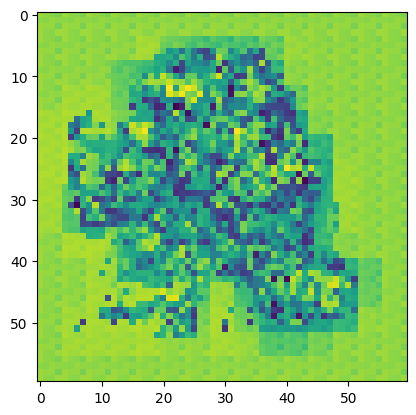

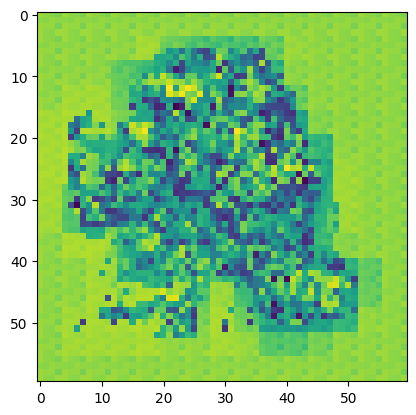

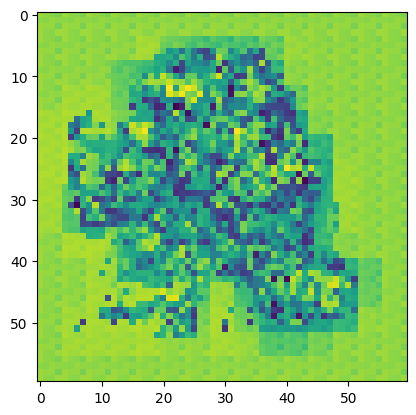

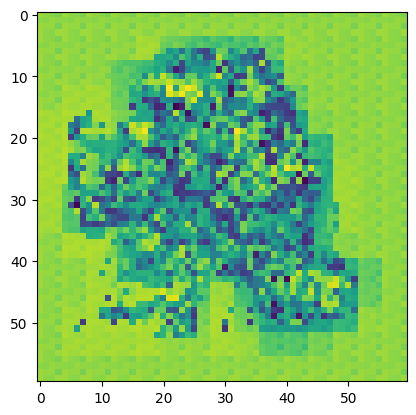

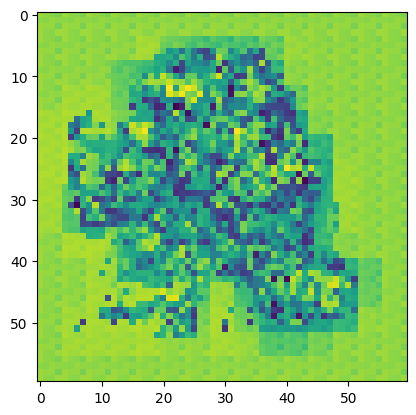

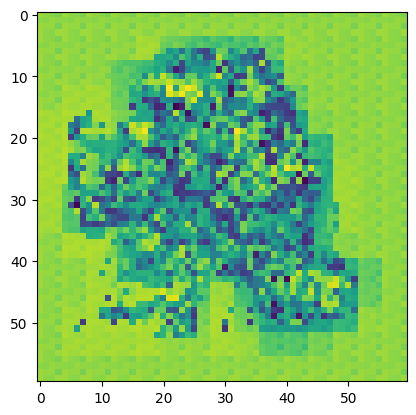

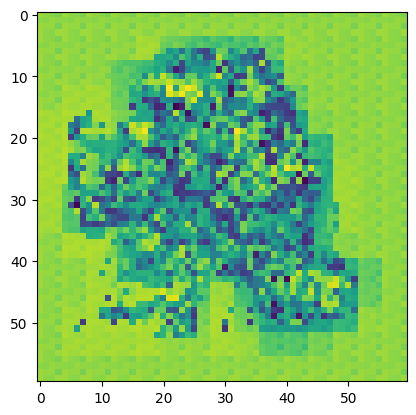

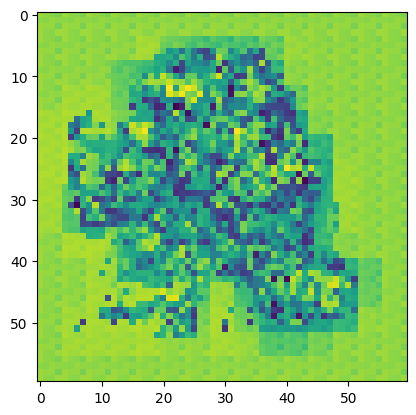

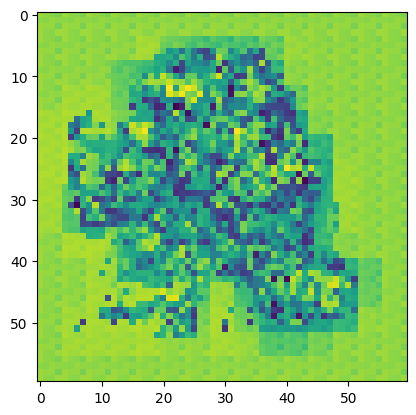

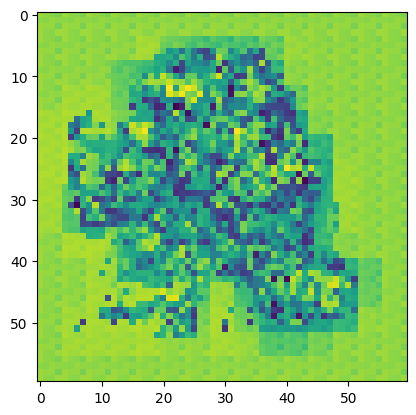

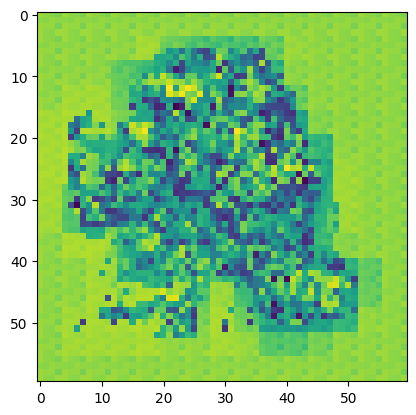

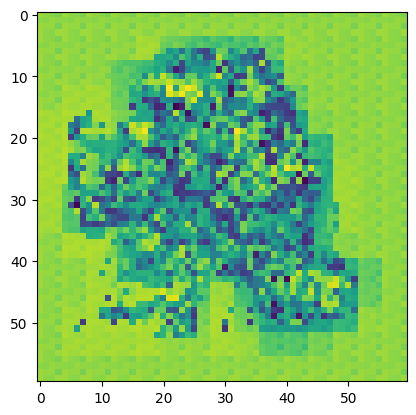

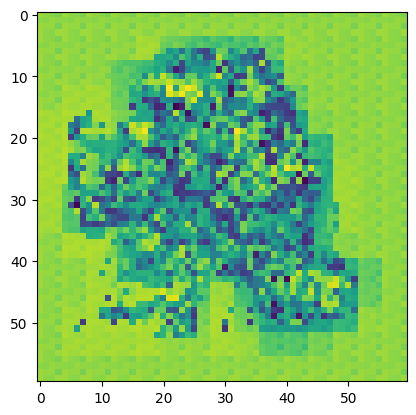

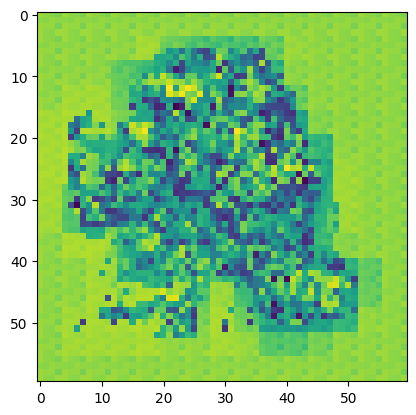

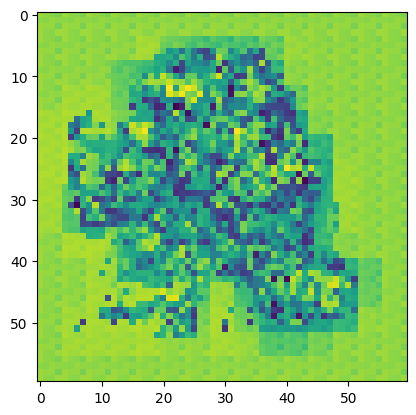

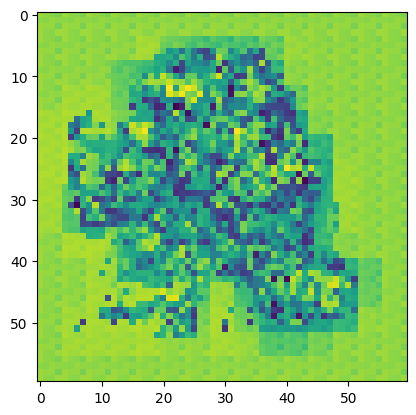

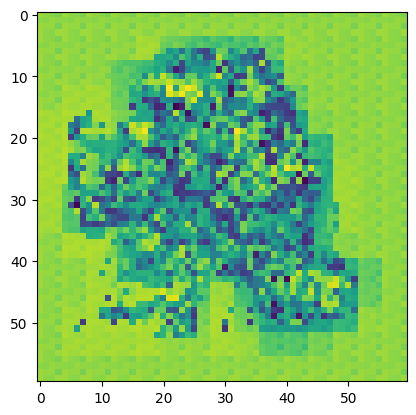

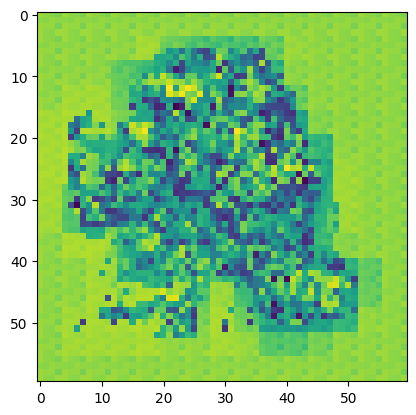

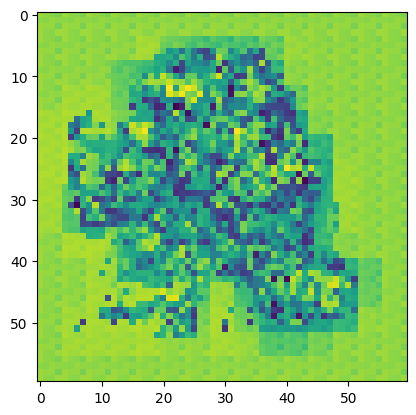

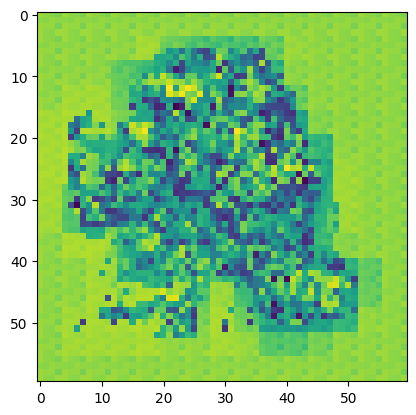

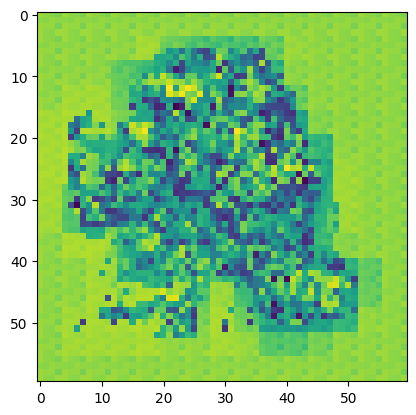

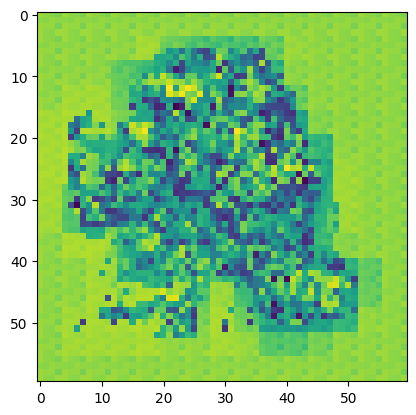

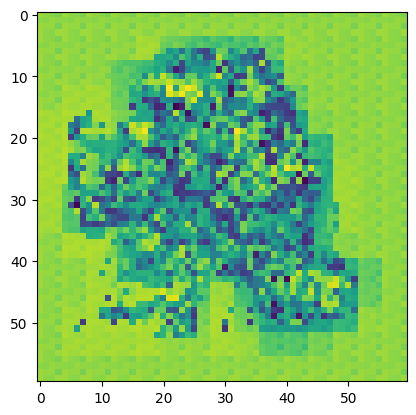

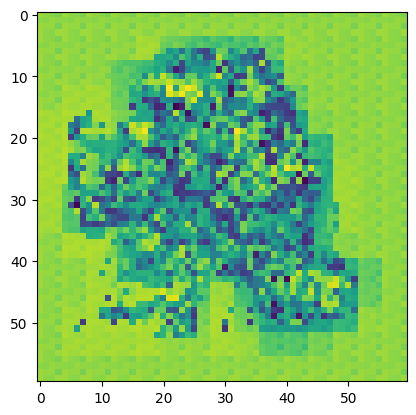

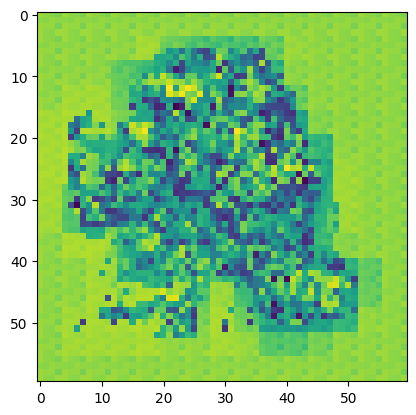

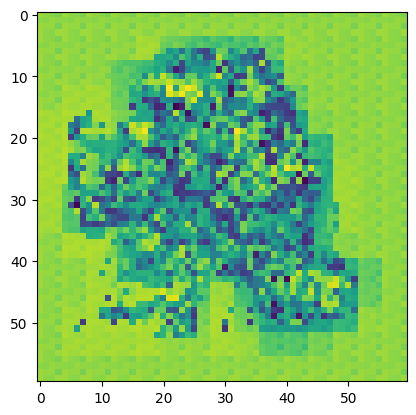

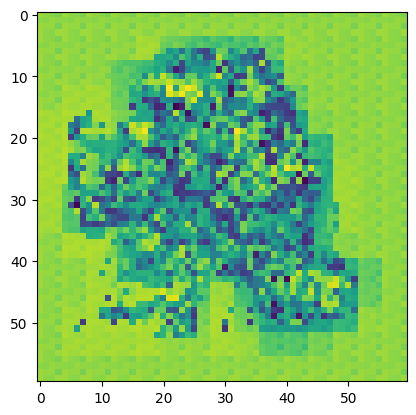

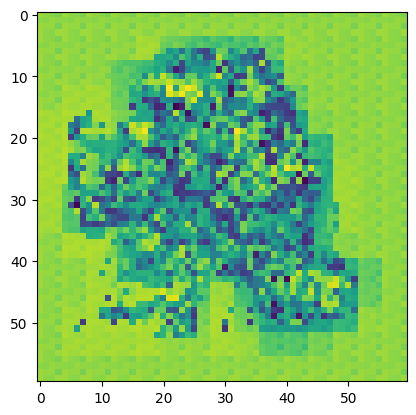

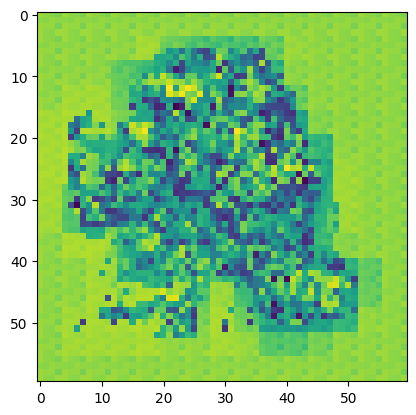

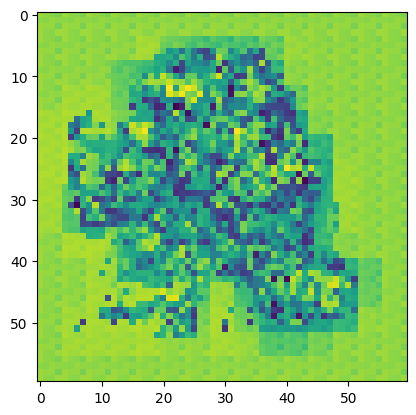

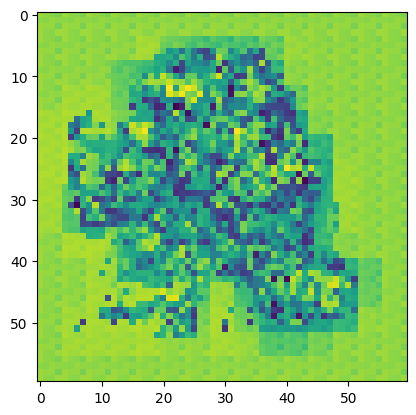

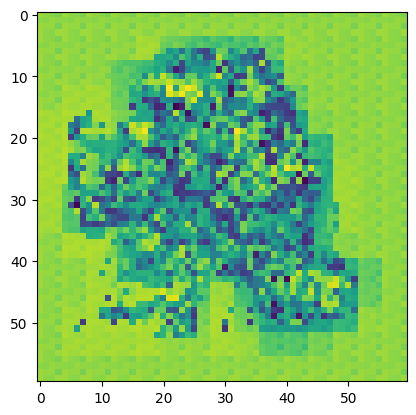

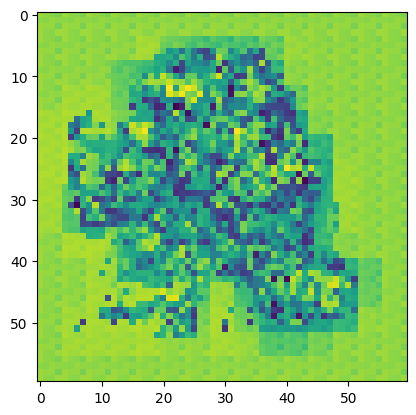

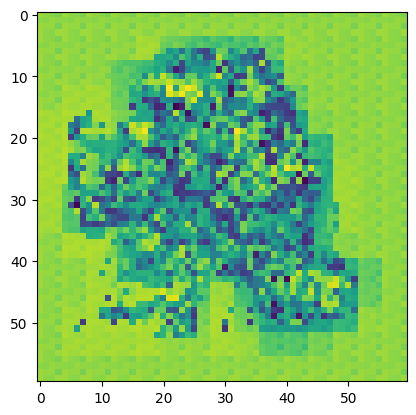

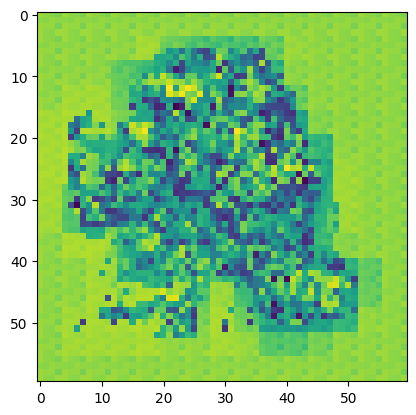

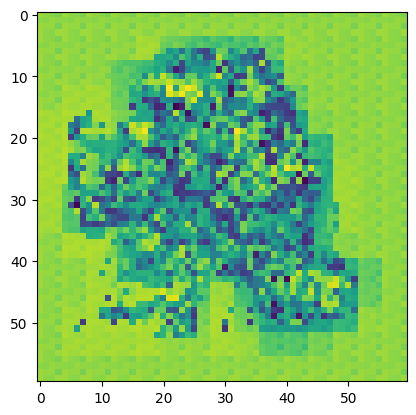

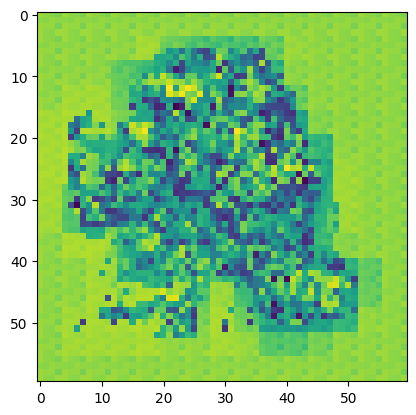

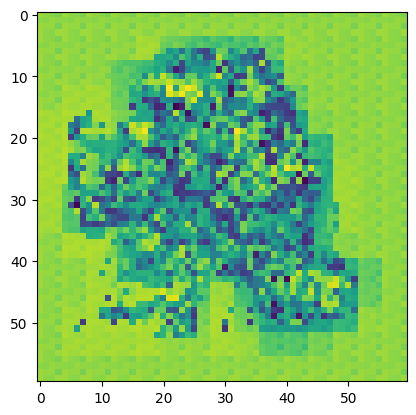

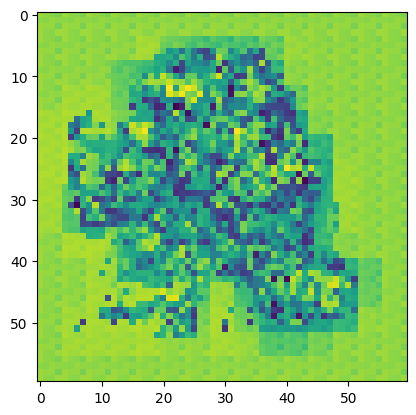

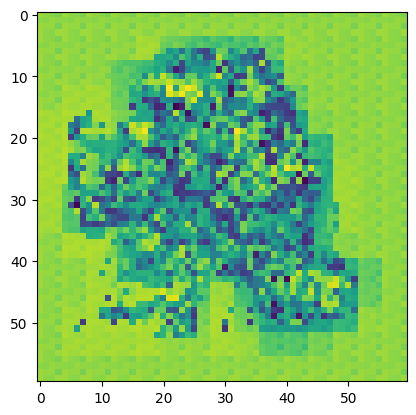

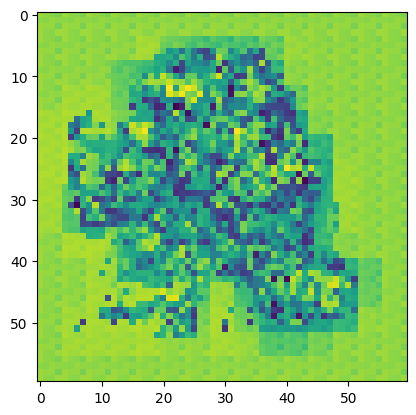

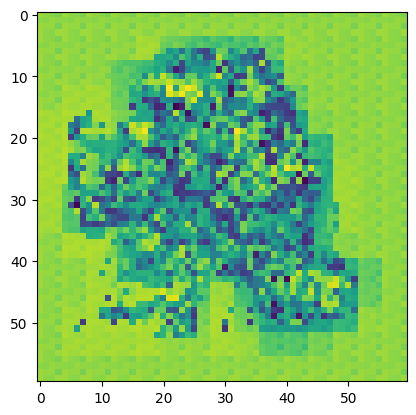

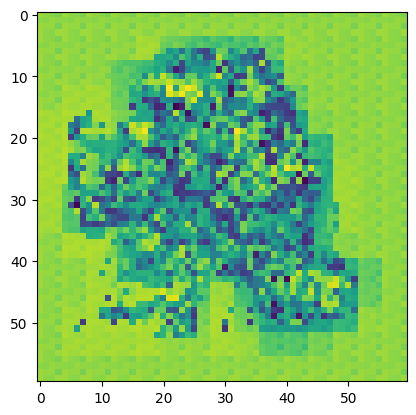

In [31]:
for i in range(100):
    plt.imshow(dists[0, :, :, i])
    plt.show()

In [22]:
# yaml.safe_dump(mushroom_config, open(os.path.join(out_dir, 'mushroom_config.yaml'), 'w'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

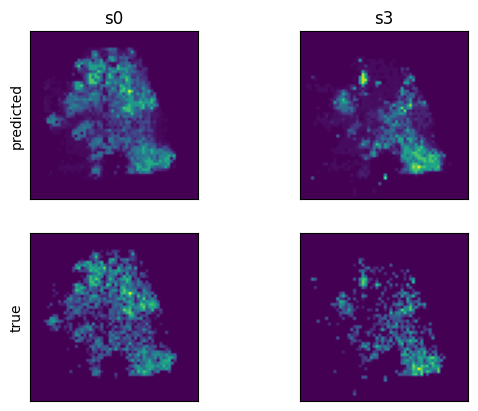

In [23]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

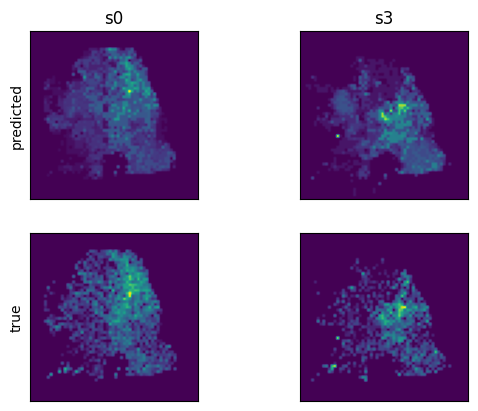

In [24]:
mushroom.display_predicted_pixels(channel='ACTA2')

In [25]:
mushroom.cluster_sections(margin=.1)

INFO:root:no background channel detected, defaulting to mean of all channels
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 13] Permission denied: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/data/estorrs/miniconda3/en

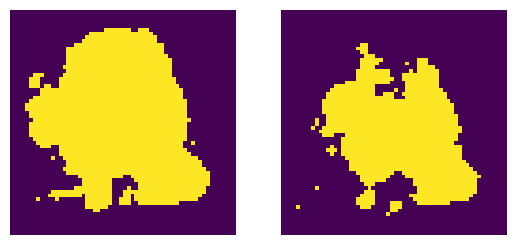

In [26]:
mushroom.clusterer.display_section_masks()

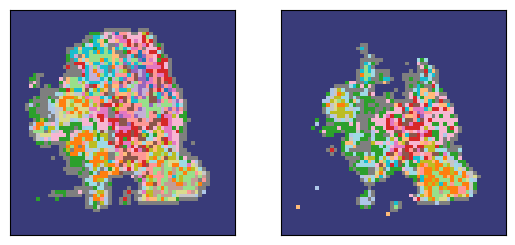

In [27]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

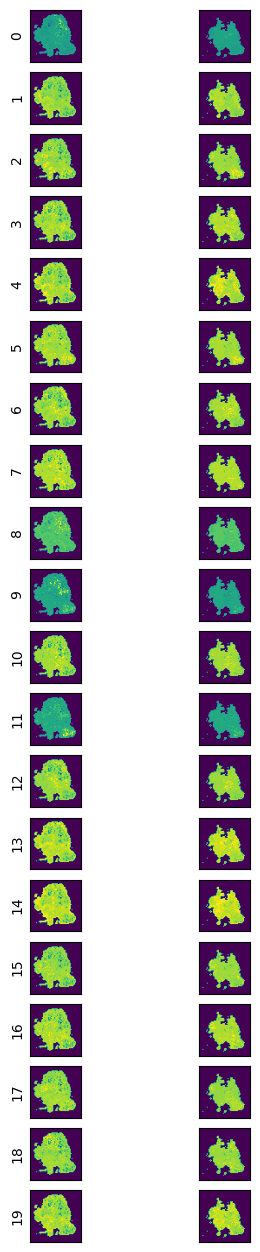

In [28]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

In [29]:
embs = mushroom.recon_embs.clone().detach().numpy()
embs.shape

(2, 256, 60, 60)

In [55]:
from einops import rearrange
x = rearrange(embs, 'n d h w -> (n h w) d')
x.shape

(7200, 1024)

In [56]:
from umap import UMAP
u = UMAP(n_components=20)
decomp = u.fit_transform(x)
decomp.shape

(7200, 20)

In [57]:
xx = rearrange(decomp, '(n h w) d -> n d h w', n=2, h=60, w=60)
xx.shape

(2, 20, 60, 60)

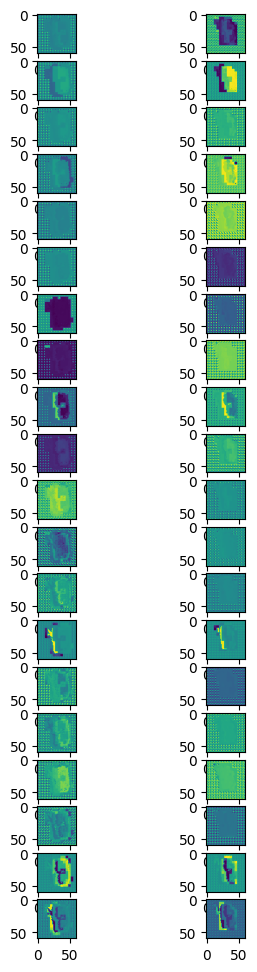

In [61]:
fig, axs = plt.subplots(nrows=xx.shape[1], ncols=xx.shape[0], figsize=(4, 12))
for i in range(xx.shape[1]):
    for j in range(xx.shape[0]):
        ax = axs[i, j]
        ax.imshow(xx[j, i])

In [ ]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [108]:
config = yaml.safe_load(open(config_fps[-3]))
config = visium_to_ome(config)

s0
s0 0 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff
s3
s3 3 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff


In [109]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath